In [21]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
#from tensorflow.keras.applications.nasnet import NASNetMobile, preprocess_input as nasnet_preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input as vgg19_preprocess_input
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Dropout, AveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#import tensorflow.keras.backend as K
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.model_selection import ShuffleSplit
#from sklearn.manifold import TSNE
import seaborn as sns
import os
import math
import time
import itertools
import glob
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib.image as mpimg
%matplotlib inline

import tensorflow as tf
print(tf.__version__)

2.0.0


In [13]:
base_dir = "./covid_aug_data"
# Train Images - Offline Augmented non-COVID19 Viral Pneumonia
#                and COVID19 Pneumonia Images 
covid_trn_dir = os.path.join(base_dir, "covid_aug")
print("In the training dataset there are: \n{} COVID19 pneumonia images".format((len(os.listdir(covid_trn_dir)))))
virus_trn_dir = os.path.join(base_dir, "virus_aug")
print("{} non-COVID19 pneumonia images".format((len(os.listdir(virus_trn_dir)))))

# Test Images Raw files without any preprocessing
covid_test_dir = os.path.join(base_dir, "covid_test")
print("\nIn the test dataset there are: \n{} COVID19 pneumonia images".format((len(os.listdir(covid_test_dir)))))
virus_test_dir = os.path.join(base_dir, "virus_test")
print("{} non-COVID19 pneumonia images".format((len(os.listdir(virus_test_dir)))))

In the training dataset there are: 
691 COVID19 pneumonia images
5437 non-COVID19 pneumonia images

In the test dataset there are: 
30 COVID19 pneumonia images
31 non-COVID19 pneumonia images


In [15]:
# File paths for the training files
covid_trn_filepaths = [covid_trn_dir + '/' + fname for fname in os.listdir(covid_trn_dir)]
virus_trn_filepaths = [virus_trn_dir + '/' + fname for fname in os.listdir(virus_trn_dir)]

# File paths for the training files
covid_test_filepaths = [covid_test_dir + '/' + fname for fname in os.listdir(covid_test_dir)]
virus_test_filepaths = [virus_test_dir + '/' + fname for fname in os.listdir(virus_test_dir)]

In [32]:
# Print an image path from each set
print(covid_trn_filepaths[1])
print(virus_trn_filepaths[1])
print(covid_test_filepaths[1])
print(virus_test_filepaths[1])

./covid_aug_data/covid_aug/covid_aug_0_3034.jpeg
./covid_aug_data/virus_aug/virus_aug_0_8716.jpeg
./covid_aug_data/covid_test/1-s2.0-S0929664620300449-gr3_lrg-a.jpg
./covid_aug_data/virus_test/person153_virus_304.jpeg


In [48]:
# Prepare train dataframe
train_df = pd.DataFrame({"image_path": virus_trn_filepaths + covid_trn_filepaths,
                         "label": ['viral'] * len(virus_trn_filepaths) + ['covid'] * len(covid_trn_filepaths)}).sample(frac=1).reset_index(drop=True)
# Shuffle the data
train_df.sample(frac=1).reset_index(drop=True)

# set the labels to 1 and 0
train_df['label_'] = train_df['label'].apply(
    lambda x: +1 if x == 'covid' else 0)

# print few random observations
train_df.sample(5)

,image_path,label,label_
5928,./covid_aug_data/virus_aug/virus_aug_0_1359.jpeg,viral,0
3651,./covid_aug_data/virus_aug/virus_aug_0_9930.jpeg,viral,0
2678,./covid_aug_data/virus_aug/virus_aug_0_3878.jpeg,viral,0
4540,./covid_aug_data/virus_aug/virus_aug_0_9704.jpeg,viral,0
2474,./covid_aug_data/virus_aug/virus_aug_0_7460.jpeg,viral,0


In [49]:
# Prepare test dataframe
test_df = pd.DataFrame({"image_path": virus_test_filepaths + covid_test_filepaths,
                        "label": ['viral'] * len(virus_test_filepaths) + ['covid'] * len(covid_test_filepaths)}).sample(frac=1).reset_index(drop=True)
# Shuffle the data
test_df.sample(frac=1).reset_index(drop=True)

# set the labels to 1 and 0
test_df['label_'] = test_df['label'].apply(lambda x: +1 if x == 'covid' else 0)

# print few random observations
test_df.sample(5)

,image_path,label,label_
59,./covid_aug_data/virus_test/person105_virus_19...,viral,0
2,./covid_aug_data/virus_test/person413_virus_84...,viral,0
52,./covid_aug_data/covid_test/1.CXRCTThoraximage...,covid,1
45,./covid_aug_data/covid_test/01E392EE-69F9-4E33...,covid,1
42,./covid_aug_data/covid_test/1-s2.0-S1684118220...,covid,1


In [37]:
def compute_prevalance(df, col):
    """
    computes the frequency of the number of observations in each class
    Arguments:
    col: The label column to compute the numbers on
    
    Returns:
    the fraction of positive and neghative numbers
    """
    assert(df.shape[0]) > 0
    N = df.shape[0] 
    prevalance = np.sum(df[col])/N
    
    return prevalance 

In [38]:
prevalance = compute_prevalance(train_df, "label_")
print(prevalance)

0.11276109660574413


In [10]:
# test_df = train_df.sample(frac=0.2)
# print(test_df.shape)

# test_idx = test_df.index

# train_df.drop(test_idx, inplace=True)
# print(train_df.shape)

In [39]:
# Shuffle data
train_df = train_df.sample(frac=1.0).reset_index(drop=True)

# Split a small fraction as valid data
valid_df = train_df.sample(frac=0.1)
print("There are {} observations in the validation data".format(valid_df.shape))

# Drop the observations in the validation data from the training data
# Extract the index values from the validation data
valid_idx = valid_df.index
# Drop these index values from the train data
train_df.drop(valid_idx, inplace=True)
print("There are {} observations in the training data".format(train_df.shape))

There are (613, 3) observations in the validation data
There are (5515, 3) observations in the training data


In [57]:
valid_df

,image_path,label,label_
2967,./covid_aug_data/covid_aug/covid_aug_0_7907.jpeg,covid,1
860,./covid_aug_data/virus_aug/virus_aug_0_9327.jpeg,viral,0
3124,./covid_aug_data/covid_aug/covid_aug_0_3639.jpeg,covid,1
3439,./covid_aug_data/virus_aug/virus_aug_0_8844.jpeg,viral,0
1587,./covid_aug_data/virus_aug/virus_aug_0_7406.jpeg,viral,0
...,...,...,...
3739,./covid_aug_data/virus_aug/virus_aug_0_6697.jpeg,viral,0
1084,./covid_aug_data/virus_aug/virus_aug_0_5535.jpeg,viral,0
4928,./covid_aug_data/virus_aug/virus_aug_0_5623.jpeg,viral,0
1624,./covid_aug_data/virus_aug/virus_aug_0_6265.jpeg,viral,0


In [43]:
prevalance = compute_prevalance(train_df, "label_")
print("Prevalance of the training data: {:.2f}%".format(prevalance*100))

prevalance = compute_prevalance(valid_df, "label_")
print("Prevalance of the testing data: {:.2f}%".format(prevalance*100))

Prevalance of the training data: 11.21%
Prevalance of the testing data: 11.91%


In [46]:
# label_encoder = LabelEncoder()

# new_labels_en = label_encoder.fit_transform(train_df['label'])
# print(new_labels_en)
# print(list(label_encoder.inverse_transform([0,1])))

[0 1 1 ... 1 1 1]
['covid', 'viral']


In [47]:
# new_labels = tf.keras.utils.to_categorical(new_labels_en, num_classes=None, dtype='float32')
# print("labels:")
# print(new_labels)

labels:
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [50]:
def get_class_weights(y):
    return class_weight.compute_class_weight('balanced', np.unique(y), y)

In [51]:
y = train_df['label']
class_weights = get_class_weights(y)
class_weights

array([4.4341534 , 0.56354607])

In [17]:
base_dir = "/floyd/home"
# Make train normal directory
output_dir = os.path.join(base_dir,'output_3')
if not os.path.isdir(output_dir):
    try: 
        os.mkdir(output_dir)
    except:
        print("Directory already exists")

In [55]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   shear_range=0.4,
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   rotation_range=45,
                                   fill_mode='nearest',validation_split=0.2)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [58]:
train_datagenerator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                        x_col='image_path',
                                                        y_col='label',
                                                        class_mode='categorical',
                                                        batch_size=32,
                                                        shuffle=True,
                                                        seed=121,
                                                        target_size=(224, 224))

valid_datagenerator = valid_datagen.flow_from_dataframe(dataframe=valid_df,
                                                        x_col='image_path',
                                                        y_col='label',
                                                        class_mode='categorical',
                                                        batch_size=32,
                                                        shuffle=True,
                                                        seed=121,
                                                        target_size=(224, 224))

test_datagenerator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                      x_col='image_path',
                                                      y_col='label',
                                                      class_mode='categorical',
                                                      batch_size=1,
                                                      shuffle=False,
                                                      seed=121,
                                                      target_size=(224, 224))

# This train generator is different from the one above with shuffle set to False
# This generator will be used to evaluate the performance of the model
train_datagenerator_02 = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                           x_col='image_path',
                                                           y_col='label',
                                                           class_mode='categorical',
                                                           batch_size=1,
                                                           shuffle=False,
                                                           seed=121,
                                                           target_size=(224, 224))

Found 6128 validated image filenames belonging to 2 classes.
Found 613 validated image filenames belonging to 2 classes.
Found 60 validated image filenames belonging to 2 classes.
Found 6128 validated image filenames belonging to 2 classes.


/Users/rajesharasada/Downloads/[/Users/rajesharasada/desktop/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


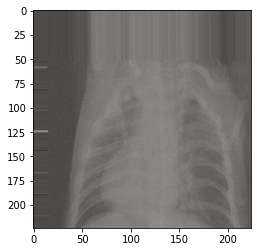

In [63]:
# Plot a random image
x, y = train_datagenerator.__getitem__(9)
plt.imshow(x[0])

In [64]:
# Instantiate the vgg19 model without the top classifier. 
base_model = VGG19(input_shape=(224, 224, 3), weights = 'imagenet', include_top = False)

# Add a classifier to the convolution block classifier
out = base_model.output
x = Flatten()(out)
# Add a  classifier
x = Dense(1024, activation='relu', name='dense_01')(x)
x = BatchNormalization(name='batch_normalization_01')(x)
x = Dropout(0.5, name='dropout_01')(x)
x = Dense(512, activation='relu', name='dense_02')(x)
x = Dropout(0.3, name='dropout_02')(x)
output = Dense(2, activation= 'softmax', name='output')(x)

# # Define the model
model_vgg19_binary_01 = Model(base_model.inputs, output)

# Freeze all layers in the convolution block. We don't want to train these weights yet.
for layer in base_model.layers:
    layer.trainable=False

model_vgg19_binary_01.summary()

# # Compile a model
model_vgg19_binary_01.compile(loss="categorical_crossentropy", optimizer=RMSprop(0.001), metrics=["accuracy"])

model_vgg19_binary_01.save("./output_3/aug_covid_model.h5")

filepath = "./output_3/aug_covid_binary_model_weights_ft.h5"
es = EarlyStopping(monitor='loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss',verbose=1, save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [23]:
# Set the number of training and validation steps
STEP_SIZE_TRAIN=train_datagenerator.n//train_datagenerator.batch_size
STEP_SIZE_VALID=valid_datagenerator.n//valid_datagenerator.batch_size

In [25]:
# Model fitting
history_01 = model_vgg19_binary_01.fit_generator(train_datagenerator,                  # Image generator
                                                 steps_per_epoch=STEP_SIZE_TRAIN,      # training steps
                                                 validation_data = valid_datagenerator,# Validation data
                                                 validation_steps=STEP_SIZE_VALID,     # validation steps
                                                 callbacks = [es,cp],                  # Check points
                                                 class_weight=class_weights,           # Class weights for imbalanced data
                                                 epochs=10)                            # number of epochs to train

Epoch 1/10
171/172 [============================>.] - ETA: 1s - loss: 0.3462 - accuracy: 0.8890
Epoch 00001: val_loss improved from inf to 2.15903, saving model to ./output_3/aug_covid_binary_model_weights_ft.h5
172/172 [==============================] - 255s 1s/step - loss: 0.3457 - accuracy: 0.8893 - val_loss: 2.1590 - val_accuracy: 0.8602
Epoch 2/10
171/172 [============================>.] - ETA: 1s - loss: 0.2339 - accuracy: 0.9173
Epoch 00002: val_loss improved from 2.15903 to 0.62811, saving model to ./output_3/aug_covid_binary_model_weights_ft.h5
172/172 [==============================] - 248s 1s/step - loss: 0.2328 - accuracy: 0.9177 - val_loss: 0.6281 - val_accuracy: 0.8799
Epoch 3/10
171/172 [============================>.] - ETA: 1s - loss: 0.2006 - accuracy: 0.9316
Epoch 00003: val_loss improved from 0.62811 to 0.57095, saving model to ./output_3/aug_covid_binary_model_weights_ft.h5
172/172 [==============================] - 247s 1s/step - loss: 0.1998 - accuracy: 0.9318 - 

In [26]:
def plot_performance(hist, model_name):
    """
    Plots the accuracy and loss during the training process.
    Args: 
    history: variable assigned to model.fit()
    model_name: A string identifying the model
    """
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    fig.suptitle("{} Training".format(model_name), fontsize=20)

    max_epoch = len(hist.history['accuracy'])+1
    epochs_list = list(range(1, max_epoch))

    ax1.plot(epochs_list, hist.history['accuracy'], color='b', linestyle='-', label='Training Data')
    ax1.plot(epochs_list, hist.history['val_accuracy'], color='r', linestyle='-', label ='Validation Data')
    ax1.set_title('Accuracy', fontsize=14)
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Accuracy', fontsize=14)
    ax1.legend(frameon=False, loc='lower center', ncol=2)

    ax2.plot(epochs_list, hist.history['loss'], color='b', linestyle='-', label='Training Data')
    ax2.plot(epochs_list, hist.history['val_loss'], color='r', linestyle='-', label ='Validation Data')
    ax2.set_title('Loss', fontsize=14)
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.set_ylabel('Loss', fontsize=14)
    ax2.legend(frameon=False, loc='upper center', ncol=2)
    
    if os.path.isdir('./output_3'):
        plt.savefig('model_{}_performance.png'.format(model_name))
    plt.show()

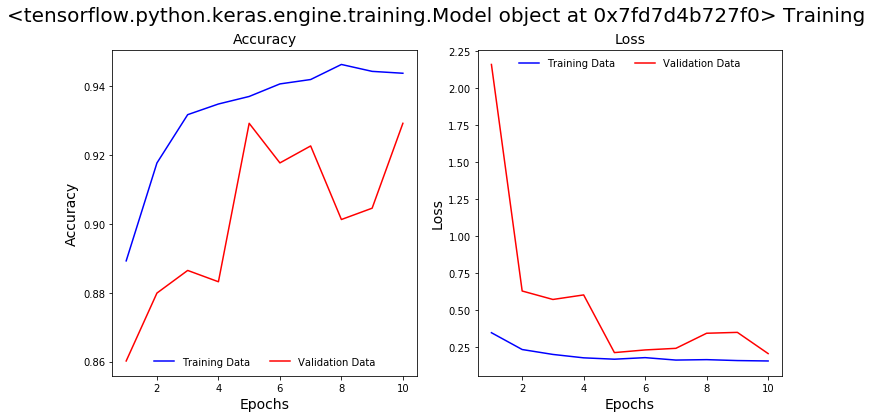

In [27]:
# Plot the performance of the model
plot_performance(history_01, model_vgg19_binary_01)

In [28]:
# Save the model
model_vgg19_binary_01.save("./output_3/model_01.h5")

In [151]:
# reload the model if you restart the kernel
model_vgg19_binary_01 = load_model("./output_3/model_01.h5")

In [68]:
model_vgg19_binary_01.load_weights('./output_3/aug_covid_binary_model_weights_ft.h5')

In [153]:
# Evaluate the model on the training data
# Make sure the data shuffle is set to false
train_eval_01 = model_vgg19_binary_01.evaluate_generator(train_datagenerator_02)

In [31]:
print('Model 01 Train loss     :{}'.format(train_eval_01[0]))
print('Model 01 Train accuracy :{}'.format(train_eval_01[1]))

Model 01 Train loss     :0.18835520484172497
Model 01 Train accuracy :0.945421576499939


In [158]:
# CLASSIFICATION REPORT ON TRAINING DATA
# Pay attention to the precision and recall of all classes
# Generate predictions(probabilities), prediction labels and true labels 
trn_predictions_01 = model_vgg19_binary_01.predict_generator(train_datagenerator_02, steps=len(train_datagenerator_02))
trn_predictions_labels_01 = np.argmax(trn_predictions_01, axis=1)
print(classification_report(train_datagenerator.classes, trn_predictions_labels_01 , 
                            target_names=['covid', 'normal']))

              precision    recall  f1-score   support

       covid       0.95      0.51      0.66       691
      normal       0.94      1.00      0.97      5437

    accuracy                           0.94      6128
   macro avg       0.94      0.75      0.82      6128
weighted avg       0.94      0.94      0.93      6128



In [162]:
# Evaluate the model on the test data
test_eval_01 = model_vgg19_binary_01.evaluate_generator(test_datagenerator)
print('Model 01 Test loss     :{}'.format(test_eval_01[0]))
print('Model 01 Test accuracy :{}'.format(test_eval_01[1]))

Model 01 Test loss     :0.38915206169379957
Model 01 Test accuracy :0.8833333253860474


In [159]:
# CLASSIFICATION REPORT ON THE TEST DATA
# Pay attention to the precision and recall of all classes
# Generate predictions(probabilities), prediction labels and true labels 
predictions_01 = model_vgg19_binary_01.predict_generator(test_datagenerator, steps=len(test_datagenerator))
predictions_labels_01 = np.argmax(predictions_01, axis=1)
print(classification_report(test_datagenerator.classes, predictions_labels_01 , 
                            target_names=['covid', 'normal']))

              precision    recall  f1-score   support

       covid       1.00      0.77      0.87        30
      normal       0.81      1.00      0.90        30

    accuracy                           0.88        60
   macro avg       0.91      0.88      0.88        60
weighted avg       0.91      0.88      0.88        60



(1.9, -0.1)

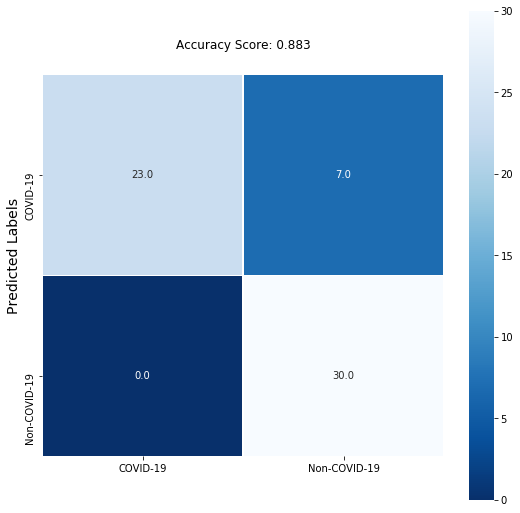

In [163]:
vgg_conf_mat_01 = pd.DataFrame(confusion_matrix(test_datagenerator.classes, predictions_labels_01), 
                               index=['COVID-19', 'Non-COVID-19'],
                               columns=['COVID-19', 'Non-COVID-19'])


fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(vgg_conf_mat_01, annot=True, fmt=".1f",
            linewidths=0.5, square=True, cmap='Blues_r')
ax.set_ylabel("True Labels", fontsize=14)
ax.set_ylabel("Predicted Labels", fontsize=14)
ax.set_title('Accuracy Score: {:.3f}'.format(test_eval_01[1]))
ax.set_ylim(len(vgg_conf_mat_01)-0.1, -0.1)

In [38]:
# Print the names of all layers in ConvNets
for idx, name in enumerate(base_model.layers):
    print(idx, name)

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f5bdf383080>
1 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5bdf3836a0>
2 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5bdf383fd0>
3 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f5bde6046a0>
4 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5bde604780>
5 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5bde61eef0>
6 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f5bde5c7208>
7 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5bde5c72e8>
8 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5bde5d2a58>
9 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5bde5cdd30>
10 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5bde5f3eb8>
11 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f5bde59b320>
12 <tensorflow.python.ke

In [70]:
# Instantiate the vgg19 model without the top classifier. 
base_model = VGG19(input_shape=(224, 224, 3),include_top = False)

# Add a classifier to the convolution block classifier
out = base_model.output
x = Flatten()(out)
# Add a  classifier
x = Dense(1024, activation='relu', name='dense_01')(x)
x = BatchNormalization(name='batch_normalization_01')(x)
x = Dropout(0.5, name='dropout_01')(x)
x = Dense(512, activation='relu', name='dense_02')(x)
x = Dropout(0.3, name='dropout_02')(x)
output = Dense(2, activation= 'softmax', name='output')(x)

# # Define the model
model_vgg19_binary_02 = Model(base_model.inputs, output)
#model_vgg19_binary_02.load_weights("./output_3/aug_covid_binary_model_weights_ft.h5")

# Freeze all layers in the convolution block. We don't want to train these weights yet.
for layer in base_model.layers[:17]:
    layer.trainable=False

model_vgg19_binary_02.summary()

# # Compile a model
model_vgg19_binary_02.compile(loss="categorical_crossentropy", optimizer=RMSprop(0.001), metrics=["accuracy"])

#model_vgg19_binary_02.save("./output_3/aug_covid_model_2.h5")

#filepath = "./output_3/aug_covid_binary_model_weights_02.h5"
es = EarlyStopping(monitor='loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss',verbose=1, save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [35]:
# Model fitting
history_02 = model_vgg19_binary_02.fit_generator(train_datagenerator,
                                                 steps_per_epoch=STEP_SIZE_TRAIN,
                                                 validation_data = valid_datagenerator,
                                                 validation_steps=STEP_SIZE_VALID,
                                                 callbacks = [es,cp],
                                                 class_weight=class_weights,
                                                 epochs=15)

Epoch 1/15
171/172 [============================>.] - ETA: 1s - loss: 0.3648 - accuracy: 0.8866
Epoch 00001: val_loss improved from inf to 1.57877, saving model to ./output_3/aug_covid_binary_model_weights_02.h5
172/172 [==============================] - 245s 1s/step - loss: 0.3636 - accuracy: 0.8871 - val_loss: 1.5788 - val_accuracy: 0.8618
Epoch 2/15
171/172 [============================>.] - ETA: 1s - loss: 0.2186 - accuracy: 0.9204
Epoch 00002: val_loss improved from 1.57877 to 0.48874, saving model to ./output_3/aug_covid_binary_model_weights_02.h5
172/172 [==============================] - 247s 1s/step - loss: 0.2179 - accuracy: 0.9205 - val_loss: 0.4887 - val_accuracy: 0.9030
Epoch 3/15
171/172 [============================>.] - ETA: 1s - loss: 0.1663 - accuracy: 0.9429
Epoch 00003: val_loss did not improve from 0.48874
172/172 [==============================] - 243s 1s/step - loss: 0.1659 - accuracy: 0.9431 - val_loss: 2.2227 - val_accuracy: 0.6135
Epoch 4/15
171/172 [=========

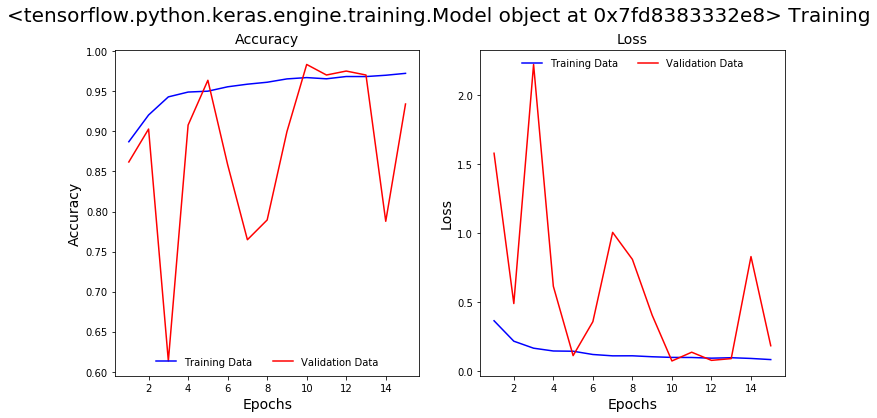

In [36]:
# Plot the performance of the model
plot_performance(history_02, model_vgg19_binary_02)

In [37]:
# Save model
model_vgg19_binary_02.save("./output_3/model_02.h5")

In [71]:
# load the trained model weights
model_vgg19_binary_02.load_weights("./output_3/aug_covid_binary_model_weights_02.h5")

In [72]:
# Evaluate the modelm performance on the training data
train_eval_02 = model_vgg19_binary_02.evaluate_generator(train_datagenerator_02)
print('Model 01 Train loss     :{}'.format(train_eval_02[0]))
print('Model 01 Train accuracy :{}'.format(train_eval_02[1]))

Model 01 Train loss     :0.09908265426224605
Model 01 Train accuracy :0.9670365452766418


In [39]:
train_eval_02 = model_vgg19_binary_02.evaluate_generator(train_datagenerator_02)

In [40]:
print('Model 01 Train loss     :{}'.format(train_eval_02[0]))
print('Model 01 Train accuracy :{}'.format(train_eval_02[1]))

Model 01 Train loss     :0.09403106417100518
Model 01 Train accuracy :0.9684497117996216


In [73]:
test_eval_02 = model_vgg19_binary_02.evaluate_generator(test_datagenerator)

In [74]:
print('Model 01 Test loss     :{}'.format(test_eval_02[0]))
print('Model 01 Test accuracy :{}'.format(test_eval_02[1]))

Model 01 Test loss     :0.15383066005573579
Model 01 Test accuracy :0.9833333492279053


In [75]:
#CLASSIFICATION REPORT ON TRAINING DATA
# Pay attention to the precision and recall of all classes
# Generate predictions(probabilities), prediction labels and true labels 
trn_predictions_02 = model_vgg19_binary_02.predict_generator(train_datagenerator_02, steps=len(train_datagenerator_02))
trn_predictions_labels_02 = np.argmax(trn_predictions_02, axis=1)
print(classification_report(train_datagenerator.classes, trn_predictions_labels_02 , 
                            target_names=['covid', 'normal']))

              precision    recall  f1-score   support

       covid       0.82      0.93      0.87       691
      normal       0.99      0.97      0.98      5437

    accuracy                           0.97      6128
   macro avg       0.90      0.95      0.93      6128
weighted avg       0.97      0.97      0.97      6128



In [76]:
# CLASSIFICATION REPORT ON THE TEST DATA
# Pay attention to the precision and recall of all classes
# Generate predictions(probabilities), prediction labels and true labels 
predictions_02 = model_vgg19_binary_02.predict_generator(test_datagenerator, steps=len(test_datagenerator))
predictions_labels_02 = np.argmax(predictions_02, axis=1)
print(classification_report(test_datagenerator.classes, predictions_labels_02 , 
                            target_names=['covid', 'normal']))


              precision    recall  f1-score   support

       covid       1.00      0.97      0.98        30
      normal       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



In [80]:
vgg_conf_mat_02 = pd.DataFrame(confusion_matrix(test_datagenerator.classes, predictions_labels_02), 
                        index=['COVID-19', 'Non-COVID-19'], 
                        columns=['COVID-19', 'Non-COVID-19'])


(1.9, -0.1)

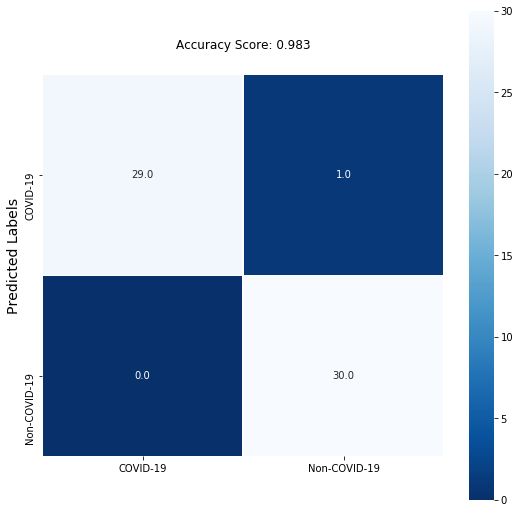

In [84]:
fig, ax = plt.subplots(figsize=(9,9))
sns.heatmap(vgg_conf_mat_02, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Blues_r')
ax.set_ylabel("True Labels", fontsize=14)
ax.set_ylabel("Predicted Labels", fontsize=14)
ax.set_title('Accuracy Score: {:.3f}'.format(test_eval_02[1]))
ax.set_ylim(len(vgg_conf_mat_02)-0.1, -0.1)

In [85]:
# Instantiate the vgg19 model without the top classifier. 
base_model = VGG19(input_shape=(224, 224, 3),include_top = False)

# Add a classifier to the convolution block classifier
out = base_model.output
x = Flatten()(out)
# Add a  classifier
x = Dense(1024, activation='relu', name='dense_01')(x)
x = BatchNormalization(name='batch_normalization_01')(x)
x = Dropout(0.5, name='dropout_01')(x)
x = Dense(512, activation='relu', name='dense_02')(x)
x = Dropout(0.3, name='dropout_02')(x)
output = Dense(2, activation= 'softmax', name='output')(x)

# # Define the model
model_vgg19_binary_03 = Model(base_model.inputs, output)
#model_vgg19_binary_03.load_weights("./output_3/aug_covid_binary_model_weights_02.h5")

# Freeze all layers in the convolution block. We don't want to train these weights yet.
for layer in base_model.layers[:12]:
    layer.trainable=False

model_vgg19_binary_03.summary()

sgd= SGD(learning_rate=1e-4, decay=1e-6, momentum=0.9, nesterov=True)

# # Compile a model
model_vgg19_binary_03.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

#model_vgg19_binary_03.save("./output_3/aug_covid_model_3.h5")

#filepath = "./output_3/aug_covid_binary_model_weights_03.h5"
es = EarlyStopping(monitor='loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss',verbose=1, save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [46]:
# Model fitting
history_03 = model_vgg19_binary_03.fit_generator(train_datagenerator,
                                                 steps_per_epoch=STEP_SIZE_TRAIN,
                                                 validation_data = valid_datagenerator,
                                                 validation_steps=STEP_SIZE_VALID,
                                                 callbacks = [es,cp],
                                                 class_weight=class_weights,
                                                 epochs=25)

Epoch 1/25
171/172 [============================>.] - ETA: 1s - loss: 0.0822 - accuracy: 0.9703
Epoch 00001: val_loss improved from inf to 0.11845, saving model to ./output_3/aug_covid_binary_model_weights_03.h5
172/172 [==============================] - 241s 1s/step - loss: 0.0817 - accuracy: 0.9705 - val_loss: 0.1185 - val_accuracy: 0.9720
Epoch 2/25
171/172 [============================>.] - ETA: 1s - loss: 0.0847 - accuracy: 0.9690
Epoch 00002: val_loss did not improve from 0.11845
172/172 [==============================] - 240s 1s/step - loss: 0.0848 - accuracy: 0.9688 - val_loss: 0.1253 - val_accuracy: 0.9655
Epoch 3/25
171/172 [============================>.] - ETA: 1s - loss: 0.0734 - accuracy: 0.9749
Epoch 00003: val_loss improved from 0.11845 to 0.06445, saving model to ./output_3/aug_covid_binary_model_weights_03.h5
172/172 [==============================] - 244s 1s/step - loss: 0.0734 - accuracy: 0.9748 - val_loss: 0.0645 - val_accuracy: 0.9868
Epoch 4/25
171/172 [=========

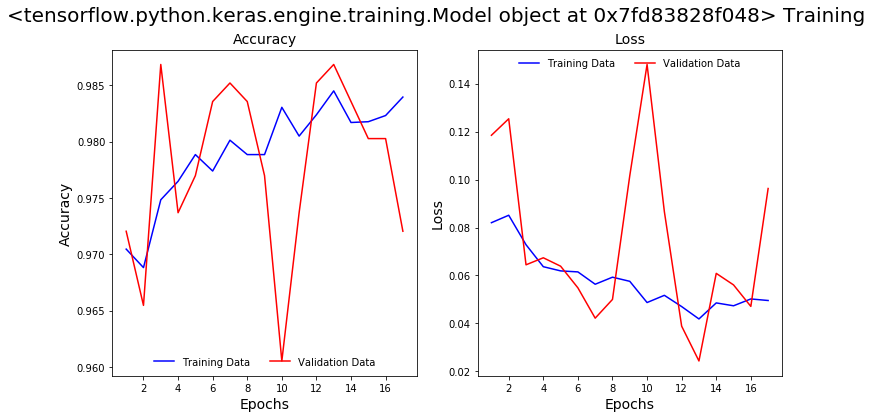

In [47]:
plot_performance(history_03, model_vgg19_binary_03)

In [86]:
### model_vgg19_binary_03.save("./output_2/model_03.h5")
model_vgg19_binary_03.load_weights("./output_3/aug_covid_binary_model_weights_03.h5")
train_eval_03 = model_vgg19_binary_03.evaluate_generator(train_datagenerator)
print('Model 03 Train loss     :{}'.format(train_eval_03[0]))
print('Model 03 Train accuracy :{}'.format(train_eval_03[1]))
test_eval_03 = model_vgg19_binary_03.evaluate_generator(test_datagenerator)
print('\nModel 03 Test loss     :{}'.format(test_eval_03[0]))
print('Model 03 Test accuracy :{}'.format(test_eval_03[1]))

trn_predictions_03 = model_vgg19_binary_03.predict_generator(train_datagenerator_02, steps=len(train_datagenerator_02))
trn_predictions_labels_03 = np.argmax(trn_predictions_03, axis=1)

# CLASSIFICATION REPORT ON THE TEST DATA
# Pay attention to the precision and recall of all classes
# Generate predictions(probabilities), prediction labels and true labels 

print(classification_report(train_datagenerator.classes, trn_predictions_labels_03 , 
                            target_names=['covid', 'normal']))

# CLASSIFICATION REPORT ON THE TEST DATA
# Pay attention to the precision and recall of all classes
# Generate predictions(probabilities), prediction labels and true labels 
predictions_03 = model_vgg19_binary_03.predict_generator(test_datagenerator, steps=len(test_datagenerator))
predictions_labels_03 = np.argmax(predictions_03, axis=1)
print(classification_report(test_datagenerator.classes, predictions_labels_03 , 
                            target_names=['covid', 'normal']))


Model 03 Train loss     :0.03589178306242502
Model 03 Train accuracy :0.9882506728172302

Model 03 Test loss     :0.22000202799155133
Model 03 Test accuracy :0.9666666388511658
              precision    recall  f1-score   support

       covid       0.96      0.93      0.94       691
      normal       0.99      0.99      0.99      5437

    accuracy                           0.99      6128
   macro avg       0.97      0.96      0.97      6128
weighted avg       0.99      0.99      0.99      6128

              precision    recall  f1-score   support

       covid       1.00      0.93      0.97        30
      normal       0.94      1.00      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



In [87]:
vgg_conf_mat_03 = pd.DataFrame(confusion_matrix(test_datagenerator.classes, predictions_labels_03), 
                        index=['COVID-19', 'Non-COVID-19'], 
                        columns=['COVID-19', 'Non-COVID-19'])

(1.9, -0.1)

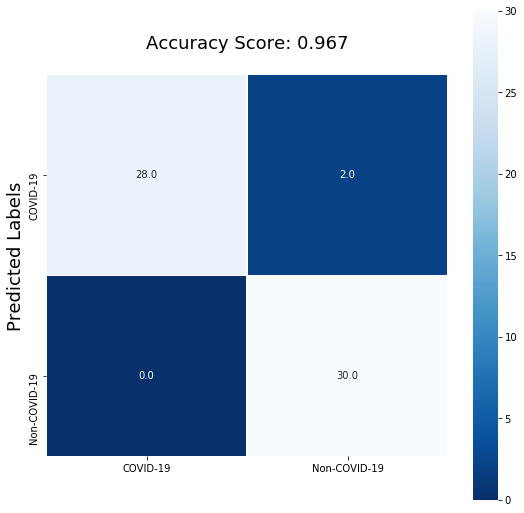

In [110]:
fig, ax = plt.subplots(figsize=(9,9))
sns.heatmap(vgg_conf_mat_03, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Blues_r',)
ax.set_ylabel("True Labels", fontsize=18)
ax.set_ylabel("Predicted Labels", fontsize=18)
ax.set_title('Accuracy Score: {:.3f}'.format(test_eval_03[1]), fontsize=18)
ax.set_ylim(len(vgg_conf_mat_03)-0.1, -0.1)

In [49]:
import itertools
from itertools import chain
training_accuracy = []
training_accuracy.append(history_01.history['accuracy'])
training_accuracy.append(history_02.history['accuracy'])
training_accuracy.append(history_03.history['accuracy'])
#print
training_accuracy_ = list(chain(*training_accuracy))


training_loss = []
training_loss.append(history_01.history['loss'])
training_loss.append(history_02.history['loss'])
training_loss.append(history_03.history['loss'])
#print
training_loss_ = list(chain(*training_loss))

validation_accuracy = []
validation_accuracy.append(history_01.history['val_accuracy'])
validation_accuracy.append(history_02.history['val_accuracy'])
validation_accuracy.append(history_03.history['val_accuracy'])
#print
validation_accuracy_ = list(chain(*validation_accuracy))

validation_loss = []
validation_loss.append(history_01.history['val_loss'])
validation_loss.append(history_02.history['val_loss'])
validation_loss.append(history_03.history['val_loss'])
#print
validation_loss_ = list(chain(*validation_loss))

In [92]:
len(training_accuracy_)
len(training_loss_)
len(validation_accuracy_)
len(validation_loss_)

31

In [53]:
covid_model_metrics = pd.DataFrame({"training_accuracy": training_accuracy_,
                                   "training_loss": training_loss_,
                                   "validation_accuracy": validation_accuracy_,
                                   "validation_loss": validation_loss_})

covid_model_metrics.to_csv("covid_model_metrics.csv", index=False)

In [91]:
df=pd.read_csv("./covid_model_metrics.csv")

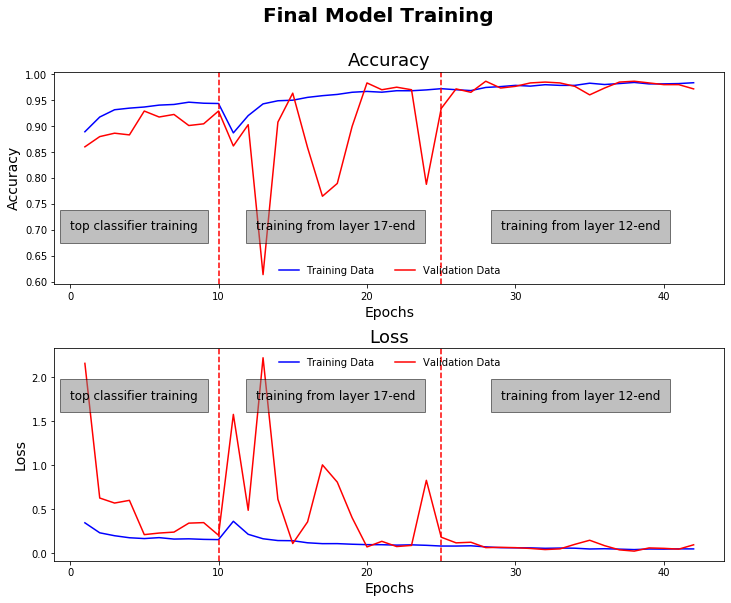

In [150]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,9))
fig.suptitle("{} Training".format("Final Model"), fontsize=20, fontweight='bold')
fig.subplots_adjust(wspace=0.3, hspace=0.3)

max_epoch = (df.shape[0])+1
epochs_list = list(range(1, max_epoch))


ax1.plot(epochs_list, df["training_accuracy"], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, df["validation_accuracy"], color='r', linestyle='-', label ='Validation Data')
ax1.axvline(10, ls='--', color='r')
ax1.axvline(25, ls='--', color='r')
ax1.set_title('Accuracy', fontsize=18)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.legend(frameon=False, loc='lower center', ncol=2)
ax1.text(0, .70, 'top classifier training', fontsize=12,
        bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
ax1.text(12.5, .70, 'training from layer 17-end', fontsize=12,
        bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
ax1.text(29, .70, 'training from layer 12-end', fontsize=12,
        bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})


ax2.plot(epochs_list, df["training_loss"], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, df["validation_loss"], color='r', linestyle='-', label ='Validation Data')
ax2.axvline(10, ls='--', color='r')
ax2.axvline(25, ls='--', color='r')
ax2.set_title('Loss', fontsize=18)
ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_ylabel('Loss', fontsize=14)
ax2.legend(frameon=False, loc='upper center', ncol=2)
ax2.text(0, 1.75, 'top classifier training', fontsize=12,
        bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
ax2.text(12.5, 1.75, 'training from layer 17-end', fontsize=12,
        bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})
ax2.text(29, 1.75, 'training from layer 12-end', fontsize=12,
        bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10})


    
if os.path.isdir('./output_3'):
    plt.savefig('model_{}_performance.png'.format("Final_Model"))
plt.show()